In [1]:
library(dplyr)
library(stringr)
library(readr)
library(tidyr)
library(lfe)
library(glmnet)
library(aod)
library(xgboost)
library(doMC)

library(foreach)
library(doParallel)
registerDoParallel(cores=5)
registerDoMC(20)

source('~/covid_mobility/paper_code/utils/residualizer+genAlters.R')
panel <- readRDS('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/data_pre_residualization.RData')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 3.0-2



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [2]:
wh <- read_csv('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/weather_history.csv')

Parsed with column specification:
cols(
  county_fips = col_double(),
  ds = col_date(format = ""),
  PRCP = col_double(),
  TMAX = col_double()
)



In [3]:
wh = select(wh, ds, county_fips, PRCP, TMAX) %>% 
arrange(ds, county_fips)
wh %>% filter(county_fips %in% panel$county_fips) -> wh

In [4]:
head(wh)
dim(wh)

ds,county_fips,PRCP,TMAX
<date>,<dbl>,<dbl>,<dbl>
2015-01-01,1001,0.00,12.76667
2015-01-01,1003,0.00,12.44000
2015-01-01,1005,0.15,14.70000
2015-01-01,1007,0.00,12.20000
2015-01-01,1009,0.00,7.80000
2015-01-01,1011,0.00,9.40000


[1] 4568652       4

In [5]:
dim(panel)

[1] 122598    379

In [6]:
panel %>% 
    select(-matches('prcp..'), 
           -matches('tmax..'),
           -matches('_Xsh'),) -> panel

In [7]:
set.seed(2345)

panel %>%
    ungroup() %>%
    select(county_fips) %>%
    distinct() %>%
    mutate(i = sample(1:n(), n(), replace = F),
            grp = i %% 3 + 1) %>%
    select(-i) -> groups

panel %>%
    left_join(groups) -> panel

Joining, by = "county_fips"



### define helper functions

In [8]:
gen_helper <- function(newPRCP, newTMAX) {
    panel %>%
        mutate(PRCP = newPRCP,
               TMAX = newTMAX,
               PRCP.fe.r = felm(PRCP ~ 0 | county_fips + ds)$resid, 
               TMAX.fe.r = felm(TMAX ~ 0 | county_fips + ds)$resid) -> FRI_df

    FRI_df %>%
        select(ds, county_fips, PRCP.fe.r, TMAX.fe.r, n) %>%
        left_join(groups) -> helper_frame
    return(helper_frame)
}

In [9]:
FRIresidualizer <- function(Y, colname, helper) {
    helper %>%
        mutate(Y = Y,
               Y.r = felm(Y ~ 0 | county_fips + ds, .)$resid) -> temp_df
    
    dm    <- xgb.DMatrix(data = model.matrix(~ 0 + PRCP.fe.r + TMAX.fe.r, temp_df), label = temp_df$Y.r)
    param <- list(max_depth=2, eta=.5, silent=1, objective='reg:linear')
    fit   <- xgb.cv(params = param, 
                    data = dm, 
                    folds = folds,
                    nrounds = 100, 
                    early_stopping_rounds = 3, 
                    weight = temp_df$n)
    best_n <- fit$best_iteration
    for (i in 1:3) {
        tr  <- temp_df %>% filter(grp != i)
        trm <- xgb.DMatrix(data = model.matrix(~ 0 + PRCP.fe.r + TMAX.fe.r, tr), label = tr$Y.r)
        fit <- xgb.train(params = param, 
                         data = trm, 
                         nrounds = best_n, 
                         weight = tr$n)
        te  <- temp_df %>% filter(grp == i)
        tem <- xgb.DMatrix(data = model.matrix(~ 0 + PRCP.fe.r + TMAX.fe.r, te), label = te$Y.r)
        te %>%
            select(county_fips, ds) %>%
            mutate(pred = predict(fit, newdata = tem)) -> pred_df
        assign(str_c('temp',i), pred_df)
    }
    out <- bind_rows(temp1, temp2, temp3) %>%
        arrange(ds, county_fips) %>%
        mutate(tempname = temp_df$Y.r - pred) %>%
        select(-pred, -ds, -county_fips)
    colnames(out) <- str_c(colname, '.r')
    return(out)
}

In [10]:
gen_FRI_data <- function(newPRCP, newTMAX) {
    
    panel %>%
        mutate(PRCP = newPRCP,
               TMAX = newTMAX,
               PRCP.fe.r = felm(PRCP ~ 0 | county_fips + ds)$resid, 
               TMAX.fe.r = felm(TMAX ~ 0 | county_fips + ds)$resid) %>%
        mutate(rain = as.numeric(PRCP > 0)) %>%     ## feel free to add instruments here
        mutate(alter_rain = weightedAlters(., WM, rain)) -> FRI_df
    ## due to how weightedAlters works, it cannot be in same mutate that the base variable was created in

    FRI_df %>%
        select(ds, county_fips, PRCP.fe.r, TMAX.fe.r, n, grp) %>%
        left_join(groups) -> helper_frame
    
    FRI_df %>% 
        select(-ds, 
               -county_fips, 
               -state_abbv, 
               -n, 
               -PRCP, 
               -TMAX, 
               -PRCP.fe.r, 
               -TMAX.fe.r, 
               -grp) %>%
        colnames() -> cols_to_xgr
    print(cols_to_xgr)
    
    xg.residuals <- foreach(i = 1:length(cols_to_xgr), .combine = cbind) %do% 
        FRIresidualizer(FRI_df[[cols_to_xgr[i]]], cols_to_xgr[i], helper_frame)
    FRI_df %>%
        bind_cols(xg.residuals) -> FRI_df
    return(FRI_df)   
}

In [11]:
panel = gen_FRI_data(panel$PRCP, panel$TMAX)

Joining, by = c("county_fips", "grp")



  [1] "sg_nhd"                      "ash_nhd"                    
  [3] "stay_home"                   "fb_btvrc"                   
  [5] "fb_rnstu"                    "ash_rnstu"                  
  [7] "sg_mcbgv"                    "log_mcbgv"                  
  [9] "ban_gmr"                     "shiftshare_11"              
 [11] "shiftshare_21"               "shiftshare_22"              
 [13] "shiftshare_23"               "shiftshare_31"              
 [15] "shiftshare_32"               "shiftshare_33"              
 [17] "shiftshare_42"               "shiftshare_44"              
 [19] "shiftshare_45"               "shiftshare_48"              
 [21] "shiftshare_49"               "shiftshare_51"              
 [23] "shiftshare_52"               "shiftshare_53"              
 [25] "shiftshare_54"               "shiftshare_55"              
 [27] "shiftshare_56"               "shiftshare_61"              
 [29] "shiftshare_62"               "shiftshare_71"              
 [31] "shi

In [12]:
names(panel)

[1] "ds"                            "county_fips"                  
  [3] "sg_nhd"                        "ash_nhd"                      
  [5] "state_abbv"                    "stay_home"                    
  [7] "PRCP"                          "TMAX"                         
  [9] "fb_btvrc"                      "fb_rnstu"                     
 [11] "ash_rnstu"                     "n"                            
 [13] "sg_mcbgv"                      "log_mcbgv"                    
 [15] "ban_gmr"                       "shiftshare_11"                
 [17] "shiftshare_21"                 "shiftshare_22"                
 [19] "shiftshare_23"                 "shiftshare_31"                
 [21] "shiftshare_32"                 "shiftshare_33"                
 [23] "shiftshare_42"                 "shiftshare_44"                
 [25] "shiftshare_45"                 "shiftshare_48"                
 [27] "shiftshare_49"                 "shiftshare_51"                
 [29] "shiftshare_52"                 "shiftshare_53"                
 [31] "shiftshare_54"                 "shiftshare_55"                
 [33] "shiftshare_56"                 "shiftshare_61"                
 [35] "shiftshare_62"                 "shiftshare_71"                
 [37] "shiftshare_72"                 "shiftshare_81"                
 [39] "shiftshare_92"                 "shiftshare_NA"                
 [41] "alter_nhd"                     "alter_sh"                     
 [43] "alter_btvrc"                   "alter_rnstu"                  
 [45] "alter_mcbgv"                   "alter_bgmr"                   
 [47] "alter_shiftshare_11"           "alter_shiftshare_21"          
 [49] "alter_shiftshare_22"           "alter_shiftshare_23"          
 [51] "alter_shiftshare_31"           "alter_shiftshare_32"          
 [53] "alter_shiftshare_33"           "alter_shiftshare_42"          
 [55] "alter_shiftshare_44"           "alter_shiftshare_45"          
 [57] "alter_shiftshare_48"           "alter_shiftshare_49"          
 [59] "alter_shiftshare_51"           "alter_shiftshare_52"          
 [61] "alter_shiftshare_53"           "alter_shiftshare_54"          
 [63] "alter_shiftshare_55"           "alter_shiftshare_56"          
 [65] "alter_shiftshare_61"           "alter_shiftshare_62"          
 [67] "alter_shiftshare_71"           "alter_shiftshare_72"          
 [69] "alter_shiftshare_81"           "alter_shiftshare_92"          
 [71] "alter_shiftshare_NA"           "geo_alter_sh"                 
 [73] "geo_alter_bgmr"                "ash_alter_nhd"                
 [75] "ash_alter_rnstu"               "log_alter_mcbgv"              
 [77] "alter_nhd_X_EgoSH"             "alter_sh_X_EgoSH"             
 [79] "alter_btvrc_X_EgoSH"           "alter_rnstu_X_EgoSH"          
 [81] "alter_mcbgv_X_EgoSH"           "alter_bgmr_X_EgoSH"           
 [83] "alter_shiftshare_11_X_EgoSH"   "alter_shiftshare_21_X_EgoSH"  
 [85] "alter_shiftshare_22_X_EgoSH"   "alter_shiftshare_23_X_EgoSH"  
 [87] "alter_shiftshare_31_X_EgoSH"   "alter_shiftshare_32_X_EgoSH"  
 [89] "alter_shiftshare_33_X_EgoSH"   "alter_shiftshare_42_X_EgoSH"  
 [91] "alter_shiftshare_44_X_EgoSH"   "alter_shiftshare_45_X_EgoSH"  
 [93] "alter_shiftshare_48_X_EgoSH"   "alter_shiftshare_49_X_EgoSH"  
 [95] "alter_shiftshare_51_X_EgoSH"   "alter_shiftshare_52_X_EgoSH"  
 [97] "alter_shiftshare_53_X_EgoSH"   "alter_shiftshare_54_X_EgoSH"  
 [99] "alter_shiftshare_55_X_EgoSH"   "alter_shiftshare_56_X_EgoSH"  
[101] "alter_shiftshare_61_X_EgoSH"   "alter_shiftshare_62_X_EgoSH"  
[103] "alter_shiftshare_71_X_EgoSH"   "alter_shiftshare_72_X_EgoSH"  
[105] "alter_shiftshare_81_X_EgoSH"   "alter_shiftshare_92_X_EgoSH"  
[107] "alter_shiftshare_NA_X_EgoSH"   "geo_alter_sh_X_EgoSH"         
[109] "geo_alter_bgmr_X_EgoSH"        "ash_alter_nhd_X_EgoSH"        
[111] "ash_alter_rnstu_X_EgoSH"       "log_alter_mcbgv_X_EgoSH"      
[113] "grp"                           "PRCP.fe.r"                    
[115] "TMAX.

### define FRI function 

In [13]:
# sample a block of dates from history
sample_date <- function(from,length) {
    
    possibleIndex = seq(length(from) - length + 1)
    firstIndex = sample(possibleIndex, 1)
    from[firstIndex:(firstIndex + length -1)]
    
}

In [14]:
fips = panel[!duplicated(panel$county_fips),'county_fips']

In [15]:
# this is the key data frame that contains IVs for all historical weathers 
wh_iv = read_csv('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/wh_iv.csv')

Parsed with column specification:
cols(
  ds = col_date(format = ""),
  county_fips = col_double(),
  PRCP = col_double(),
  TMAX = col_double(),
  alter_rain.r = col_double()
)



In [16]:
# takes historical weather and draws counterfactual weather
make_weather_permutations <- function(wh, n_sims, years = 4, time_window = 28) {
    
    foreach(i = 1:n_sims) %do% {
        dates <- unique(panel$ds)

        year = sample(c(1:years), 1) # to go back how many years

        d_history = seq.Date(
            from = min(dates) - 365 * year - time_window, 
            to = max(dates) - 365 * year + time_window, 
            by = 1
        )

        d_sample = as.Date(sample_date(d_history, length(dates)))

        d_sample_order <- data.frame(
            ds = d_sample,
            current_ds = dates
        )

        weather_sample = wh %>% 
            inner_join(d_sample_order, by = "ds")

        weather_sample = left_join(fips, weather_sample, "county_fips")
        # TODO: Jeremy had some additional logic for filling in 0s here. Needed?
        weather_sample
    }
}

In [17]:
# draw weather IVs from all historical weather data
weather_permutations = make_weather_permutations(wh_iv, years = 4, n_sims = 1000)

In [18]:
head(weather_permutations[[1]])

county_fips,ds,PRCP,TMAX,alter_rain.r,current_ds
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<date>
1001,2017-03-04,0.00000,19.06667,-0.09923613,2020-03-01
1001,2017-03-05,0.00000,18.66667,-0.09117832,2020-03-02
1001,2017-03-06,0.00000,22.13333,-0.20198433,2020-03-03
1001,2017-03-07,0.00000,22.66667,0.19942068,2020-03-04
1001,2017-03-08,20.16667,22.26667,0.04338635,2020-03-05
1001,2017-03-09,32.00000,24.86667,-0.08373843,2020-03-06


In [19]:
# conduct Fisherian randomization inference
# assumes that test_function give a statistic appropriate for a one-sided test
# permutations: a list of alternative panels of eg weather

do_fri <- function(data, 
                   test_function, 
                   permutations, 
                   n_sims = length(permutations)) {
    
    if (length(permutations) < n_sims) stop("not enough permutations")
    
    do_one_permutation <- function(permutation) {
        # remove columns to replace
        cols <- names(permutation)[!names(permutation) %in% c("county_fips", "ds", 'fb_btvrc.r',
                                                             "ban_gmr.r", "geo_alter_bgmr.r", "alter_bgmr.r",
                                                              "stay_home.r", "geo_alter_sh.r", "alter_sh.r")]
        data[cols] <- NULL
        
        # join to replace columns
        data <- data %>% left_join(permutation, by = c("county_fips", "ds" = "current_ds"))
        
        #FRI <- gen_FRI_data(data$PRCP, data$TMAX)
        
        #cat(dim(data), "\n")
        #cat(sum(is.na(data$oR1)), "\n")
        test_function(data)
    }
    
    results <- foreach(i = 1:n_sims, .combine = c) %dopar% {
        do_one_permutation(permutations[[i]])
    }
    
    results <- data.frame(null_test_statistic = results)
    
    obs_result <- test_function(data)
    
    results$obs_test_statistic <- obs_result
    
    list(
        draws = results,
        test_statistic = obs_result,
        p_value = mean(obs_result < results)
    )
}

### do FRI

In [20]:
# function to compute our test statistic
formula_1 <- fb_btvrc.r ~ 0 + ban_gmr.r + geo_alter_bgmr.r + alter_bgmr.r + 
            stay_home.r + geo_alter_sh.r + alter_sh.r + alter_rain.r| county_fips + ds | 0 | state_abbv

wald_formula_1 <- ~ alter_rain.r

get_relevant_fstat <- function(df, formula = formula_1, wald_formula = wald_formula_1) {
    fm <- felm(
        formula,
        data = df,
        weights = df$n
    )
    waldtest(fm, wald_formula)['F']
}

In [21]:
fri_result <- do_fri(
    panel,
    get_relevant_fstat,
    weather_permutations
)

In [22]:
n_distinct(fri_result$draws$null_test_statistic)

[1] 224

In [23]:
fri_result$p_value

[1] 0.0085

In [24]:
library(ggplot2)

In [25]:
mean(fri_result$test_statistic < unique(fri_result$draws$null_test_statistic))

[1] 0.02232143

In [28]:
ggplot(
    aes(x = null_test_statistic),
    data = fri_result$draws %>% distinct(null_test_statistic,.keep_all=T)
) + geom_histogram() + 
    geom_vline(xintercept = fri_result$test_statistic, color = "red") +
    theme_bw() +
    xlab("F-statistic") -> test1

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



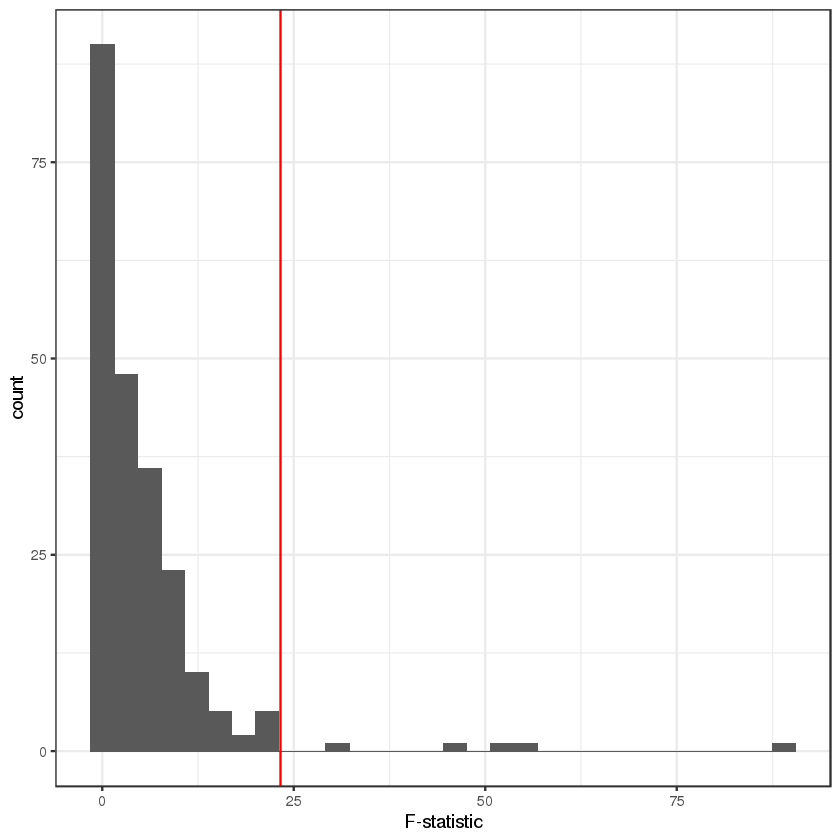

In [32]:
test1

In [29]:
ggsave(
  paste0("fri_test1.pdf"),
  plot = test1,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 7.5,
  height = 10,
  units = c("in"),
  dpi = 200,
  limitsize = FALSE,
  useDingbats=FALSE
)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

